In [98]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import h5py
from peakfinder import detect_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import scipy as sp
from sklearn.metrics import classification_report
#import similaritymeasures
from PIL import Image
from tqdm import tqdm_notebook as tqdm

In [99]:
df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\alt labels.txt',delimiter = '\s+',header = None,index_col = None)
#df_labels = pd.read_csv(r'/Users/kunal/OneDrive - The Open University/SPIN/Transmission/Scripts/alt labels.txt',delimiter = '\s+',header = None,index_col = None)

df_labels.columns = ['File','Label']
df_labels = df_labels.drop(df_labels[df_labels.Label == 6].index)
#df_labels = df_labels[df_labels.Label != 6]

In [100]:
df_labels.iloc[71]

File     20180616_220310_1p0_UVIS_U.h5
Label                                3
Name: 75, dtype: object

In [101]:
z = []
y = []

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

f_wav = 250

rootDir = r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations'
#rootDir = r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations'
os.chdir(rootDir)
list_of_files = os.listdir(os.getcwd())

for each_df_file in df_labels['File']:
    for each_file in list_of_files:
        if each_file.startswith(each_df_file):
            
            file = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations\%s' %each_file,'r')
            #file = h5py.File(r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations/%s' %each_file,'r')

            
            T = np.array(file['Science/Transmission'])
            TangAlt = np.array(file['Geometry/Point0/TangentAltSurface'])
            wav = np.array(file['Science/Wavelength'])

            avg_TangAlt = []

            for j in range(TangAlt.shape[0]):
                avg_TangAlt.append(np.mean(TangAlt[j,:]))



            T_wav = T[:,np.array(np.where(wav == find_nearest(wav,f_wav))).flatten()].reshape(-1,)

            if T_wav[0] > 0.5:
                T_wav = T_wav[::-1]

            z.append(T_wav)
            
            if avg_TangAlt[0] > 100:
                avg_TangAlt = avg_TangAlt[::-1]
            
            y.append(avg_TangAlt)
            
z = np.array(z)
y = np.array(y)

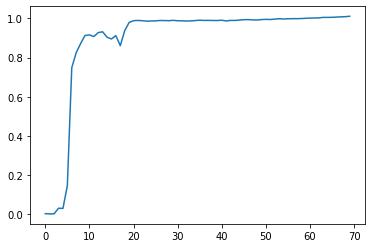

In [102]:
plt.plot(z[71])

In [103]:
def show_false_files(pred_classes, show_files = False):
    
    false_files = np.array(df_labels.File.iloc[id_test[np.where(abs(pred_classes-y_test) != 0)]])
    df_false = pd.DataFrame(columns=['File','True Label','Predicted Label'],index=id_test[np.where(abs(pred_classes-y_test) != 0)])
    df_false['File'] = false_files
    a = []
    b = []
    for i in range(len(y_test)):
        if abs(pred_classes[i]-y_test[i]) != 0:
            a.append(y_test[i])
            b.append(pred_classes[i])

    df_false['True Label'] = a
    df_false['Predicted Label'] = b
    df_false.sort_index(inplace = True)

    if show_files:
        os.chdir(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Plot_%snm' %f_wav)
        file_list = os.listdir()
        for each_file in file_list:
            for _ in false_files:
                if each_file.startswith(_):
                    img = Image.open(each_file)
                    img.show()
                    
        
    return df_false

In [104]:
alt_interp = np.arange(0,274,1)
t_interp = []
for i in range(len(z)):
    z_interp = np.interp(alt_interp,y[i],z[i])
    t_interp.append(z_interp)
t_interp = np.array(t_interp)
t_interp[t_interp < 0] = 0

In [105]:
df_labels = df_labels[df_labels.Label != 6]
indices = np.arange(len(np.array(df_labels['Label'])))
X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_interp, np.array(df_labels['Label']),indices, test_size=0.33)

In [120]:
pred_labels = []

for j,t in enumerate(X_test):
    
    peak_idx = detect_peaks(t,mph=0.05)
    valley_idx = detect_peaks(t,mph = 0.963, valley = True)

    p_structure = []
    v_structure = []
    
    for peak in peak_idx:
        if t[peak] < 0.963:
            p_structure.append(peak)
            
    for valley in valley_idx:
        if t[valley] > 0.02:
            v_structure.append(valley)
            
    p_structure = np.array(p_structure)
    v_structure = np.array(v_structure)
            
    
    if len(v_structure) == 0: #smooth
        pred_labels.append(0)
        print(id_test[j],0)
        
    else:
        if all(k <= 50 for k in v_structure):
            pred_labels.append(1)
            print(id_test[j],1)
        elif all(50 < k <= 100 for k in v_structure): # low alt
            if all(i <= 50 for i in p_structure):
                pred_labels.append(3)
                print(id_test[j],3.1)
            else:
                pred_labels.append(2)
                print(id_test[j],2)
        elif all(k > 100 for k in v_structure): # mid alt
            pred_labels.append(4)
            print(id_test[j],4)
        else:
            pred_labels.append(3)
            print(id_test[j],3)

pred_labels = np.array(pred_labels)

75 1
107 1
86 1
64 0
3 0
97 1
92 3
47 0
88 1
39 2
84 0
35 3
58 1
25 1
93 0
29 1
67 0
1 0
41 0
62 0
77 0
94 3
102 3
69 0
20 0
14 1
54 0
103 0
87 0
46 0
49 0
15 1
27 3
9 0
101 3
5 0


In [117]:
print(classification_report(pred_labels,y_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.89      0.80      0.84        10
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6

    accuracy                           0.92        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.92      0.92      0.92        36



In [118]:
show_false_files(pred_classes=pred_labels)

,File,True Label,Predicted Label
14,20180501_235421_1p0_UVIS_U.h5,0.0,1
29,20180523_032150_1p0_UVIS_U.h5,0.0,1
87,20180619_094121_1p0_UVIS_E.h5,1.0,0


[] [18]


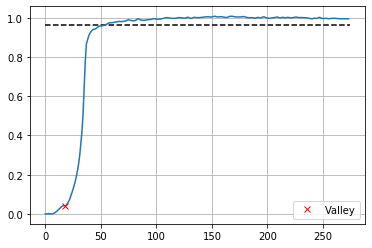

In [122]:
i = 14

plt.plot(t_interp[i])
peak_idx = detect_peaks(t_interp[i],mph=0.05)
valley_idx = detect_peaks(t_interp[i],mph = 0.963, valley = True)

p_structure = []
v_structure = []
    
for peak in peak_idx:
    if t_interp[i,peak] < 0.963:
        p_structure.append(peak)

for valley in valley_idx:
    if t_interp[i,valley] > 0.02:
        v_structure.append(valley)

p_structure = np.array(p_structure)
v_structure = np.array(v_structure)

print(p_structure,v_structure)

if len(p_structure) != 0:
    plt.plot(p_structure,t_interp[i,p_structure],'kx',label = 'Peak')
if len(v_structure) != 0:
    plt.plot(v_structure,t_interp[i,v_structure],'rx',label = 'Valley')
plt.hlines(0.963,0,274,linestyles='dashed')
plt.legend(loc = 'lower right')
plt.grid()

In [115]:
t_interp[i,valley_idx]

array([0.        , 0.04139528])